In [1]:
pwd

'/home/benjaminkroeger/jupyter_notebooks'

In [2]:
cd ~/gene_regulatory_networks/data


/home/benjaminkroeger/gene_regulatory_networks/data


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 leidenalg==0.8.2


In [5]:
results_file = '/home/benjaminkroeger/gene_regulatory_networks/data/write/pbmc3k.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_mtx('/home/benjaminkroeger/gene_regulatory_networks/data/filtered_gene_bc_matrices/hg19/', # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

... reading from cache file cache/home-benjaminkroeger-gene_regulatory_networks-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [7]:
adata.var_names_make_unique() # appends numberstring to non unique elemetns 

In [8]:
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


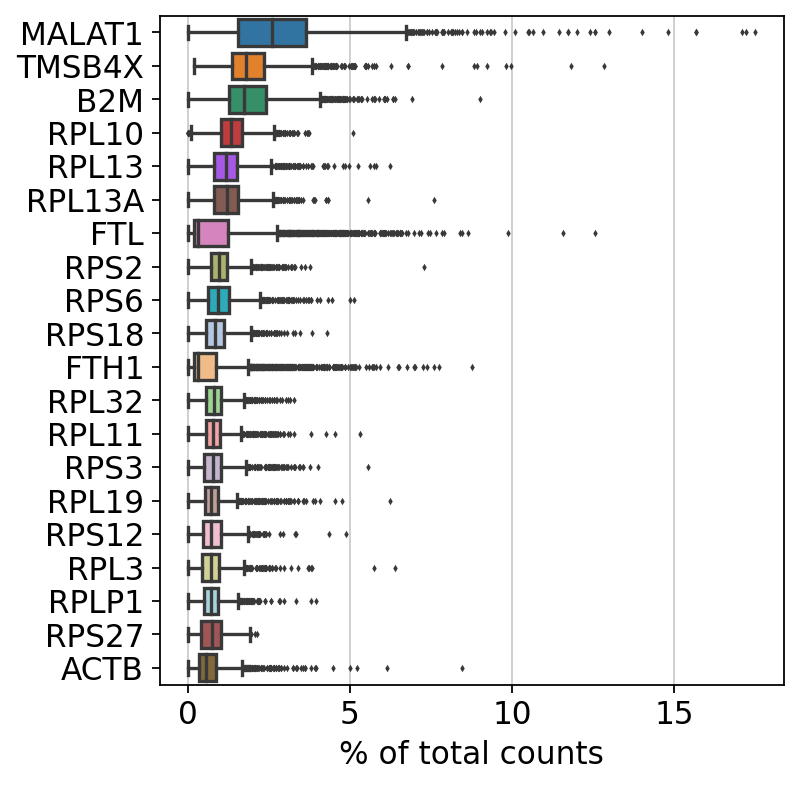

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [10]:
sc.pp.filter_cells(adata, min_genes=200) # only keep cells with at least 200 genes expressed ; reducing lines
sc.pp.filter_genes(adata, min_cells=3) # only keep genes that are at least expressed in 3 cells ; reducing columns

filtered out 19024 genes that are detected in less than 3 cells


In [11]:
# sets the mt column to true for every gene starting with MT-
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt' sets mt to true
# ??
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'>

/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seabo

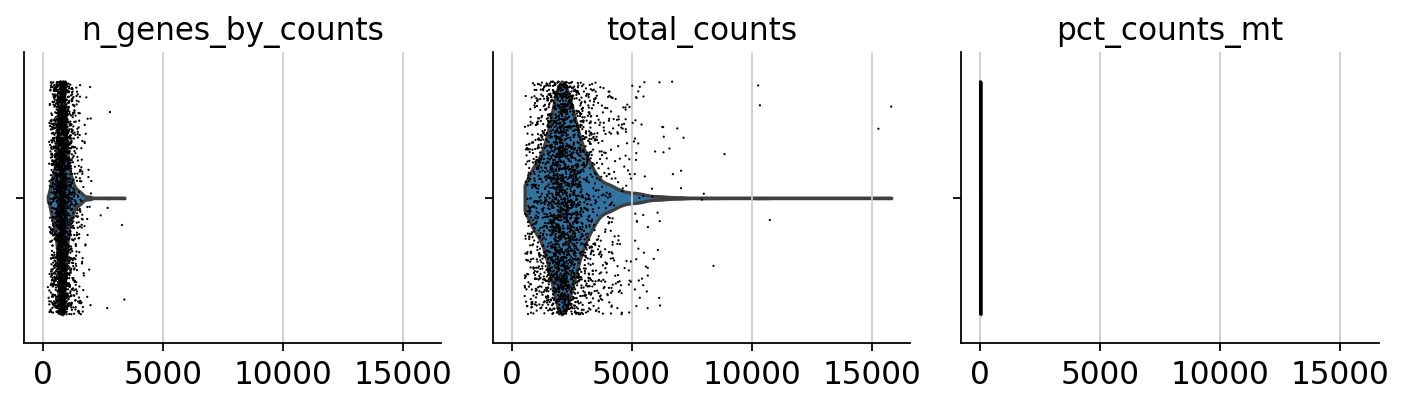

In [13]:
#plots how often each value of the specific feature occurs
#n_genes_by_count = 
#total_counts = 
#pct_counts_mt= percentage of mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


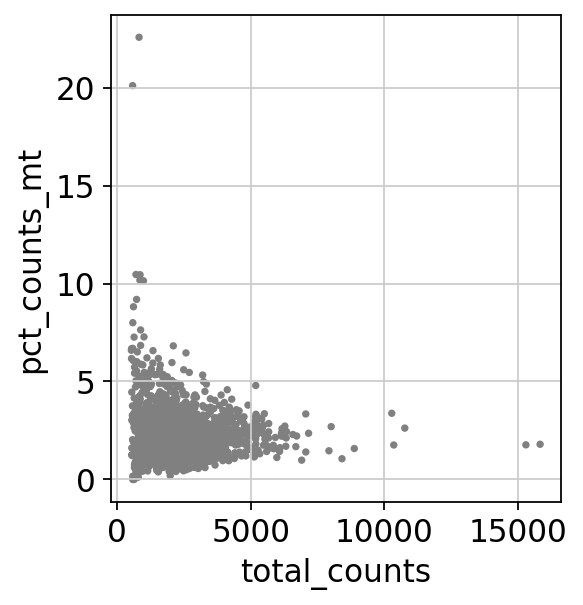

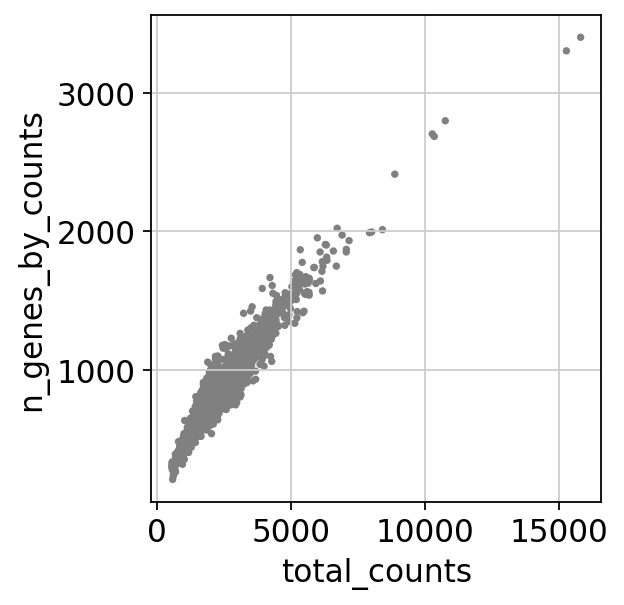

In [14]:
# high amount of Mitochondrial genes indicates a poor quality cell; why ??
# if there are few counts and most of them are mt then the cell is of bad qulity 
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# see whether 2 cells were sequenced at the same time therefore getting to many resuts == outliners
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
# keep all cells that have less than certain counts
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# only keep cells with less dann 5% mt genes
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
# projecting existing values into a certain space

normalizing counts per cell
    finished (0:00:00)


/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
sc.pp.log1p(adata)

In [18]:
# marking some genes as highly variable

# housekeeping genes are not of interest and can be discarded
# alternative: 
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
# just taking top 2000 variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# 

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


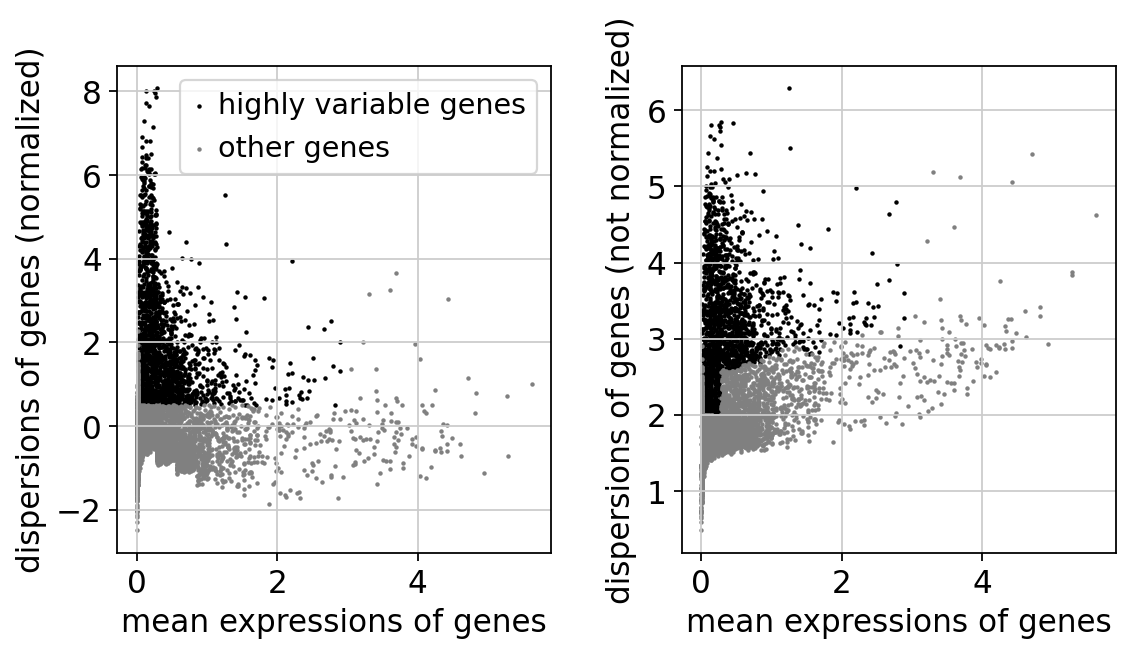

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata.raw = adata
#store everythign

In [21]:
adata= adata[:, adata.var.highly_variable]
#only keep highly variale

In [22]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# remove the effect of these obs

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [23]:
sc.pp.scale(adata, max_value=10)

In [24]:
sc.tl.pca(adata, svd_solver='arpack')
# 2000 genes / dimensions

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


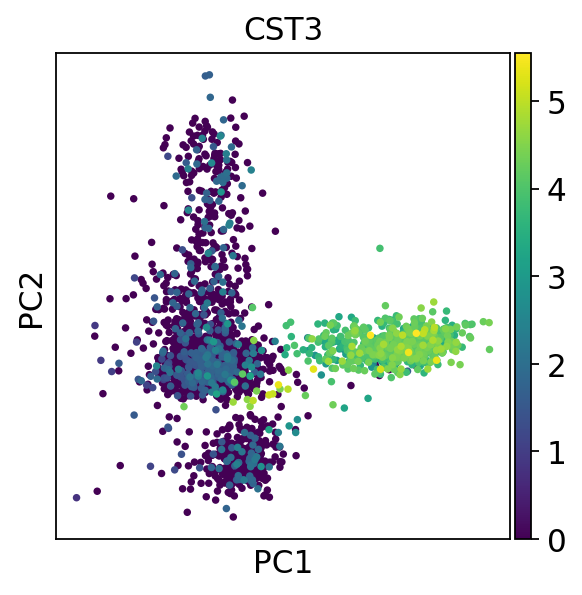

In [25]:
sc.pl.pca(adata, color='CST3')

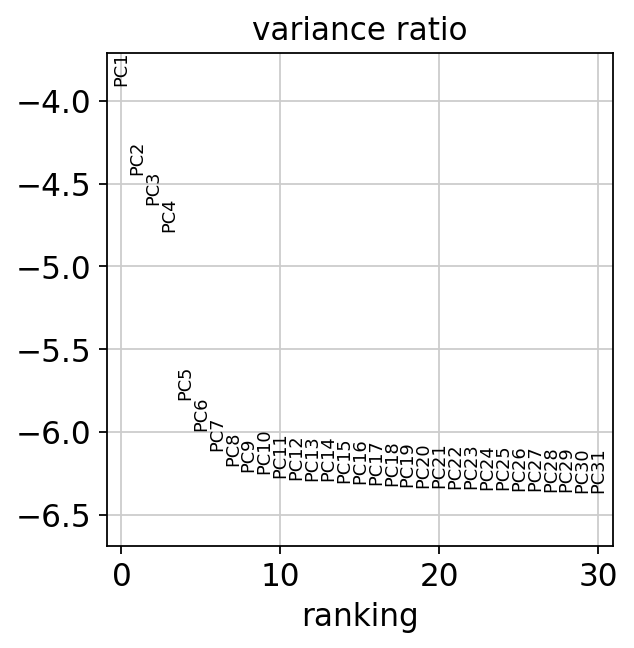

' roughly 10 PCA are enough to represent'

In [26]:
sc.pl.pca_variance_ratio(adata, log=True)
#elbowplot 
' roughly 10 PCA are enough to represent'

In [27]:
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# use langht of the 40 pca vector

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [30]:
# computes the nearest neighbors of each bar code based on PCAs

# stores the data in obsp : Cell by cell graph
# obsp like dict 
# obsp stores for each key an higher dimensional ndarray here 10
# obsp relates to whole data
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [31]:
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
# umap is a technique to visualize high dimensional data
# umap conserves structure
# represent topology of the data
# obsm stores for each key an ndarray ??
sc.tl.umap(adata)

# X_umap coordiante for later plotting

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


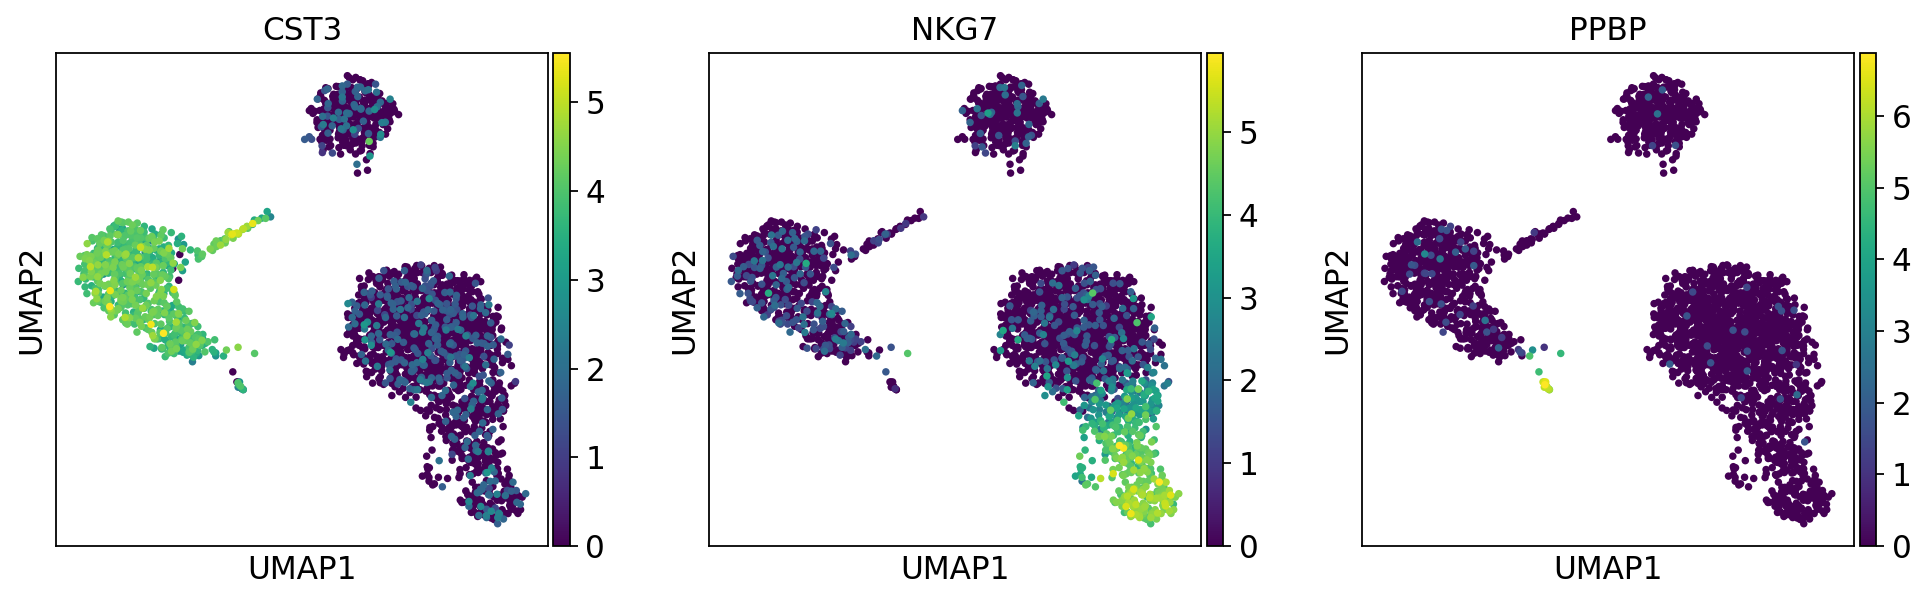

In [33]:
# plot data with umap and highlight different genes
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

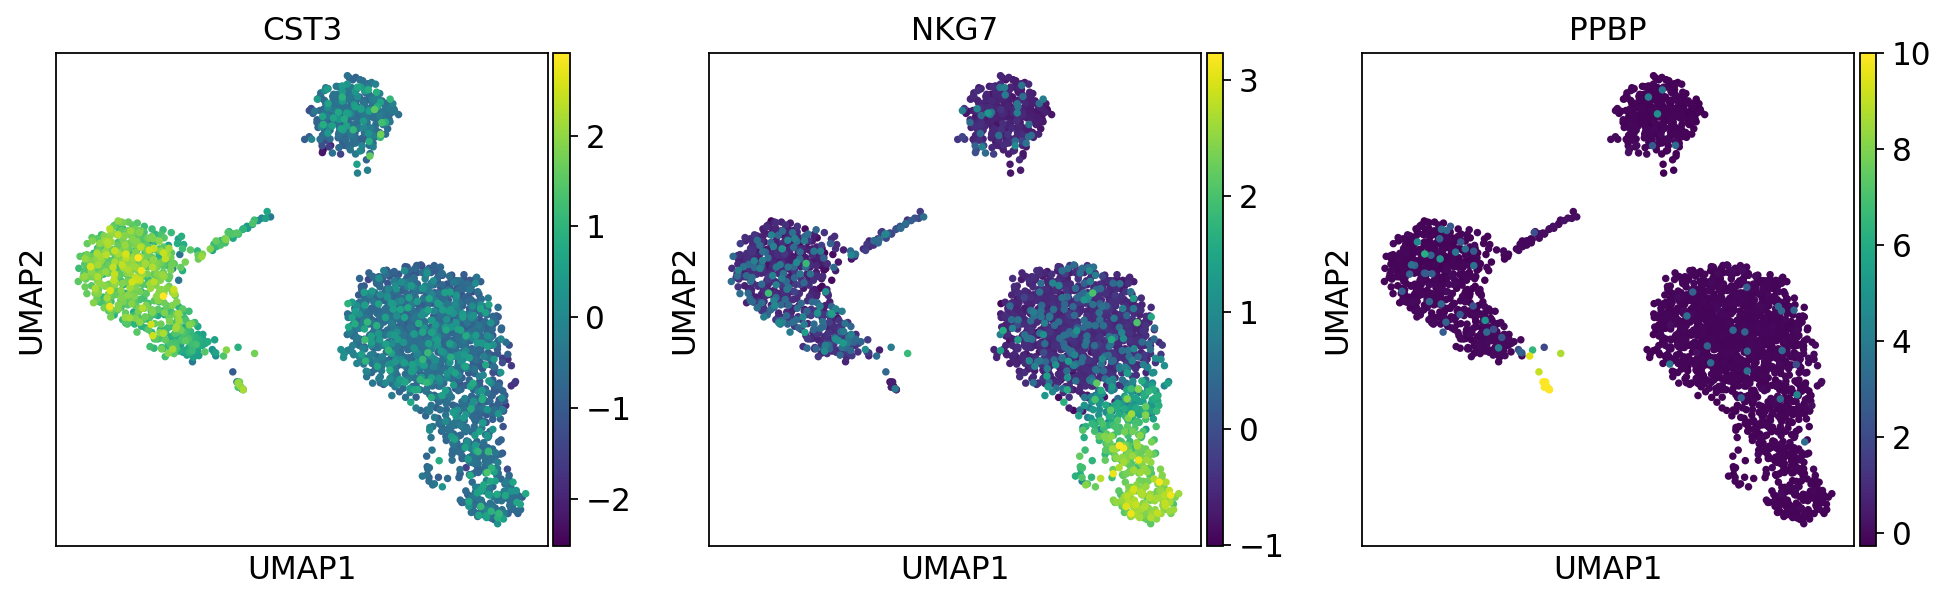

In [34]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [35]:
# leiden graph clusters the neighborhood graph of cells
# where a group o genes is expressed uniquely = cluster
sc.tl.leiden(adata, resolution=0.15)

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


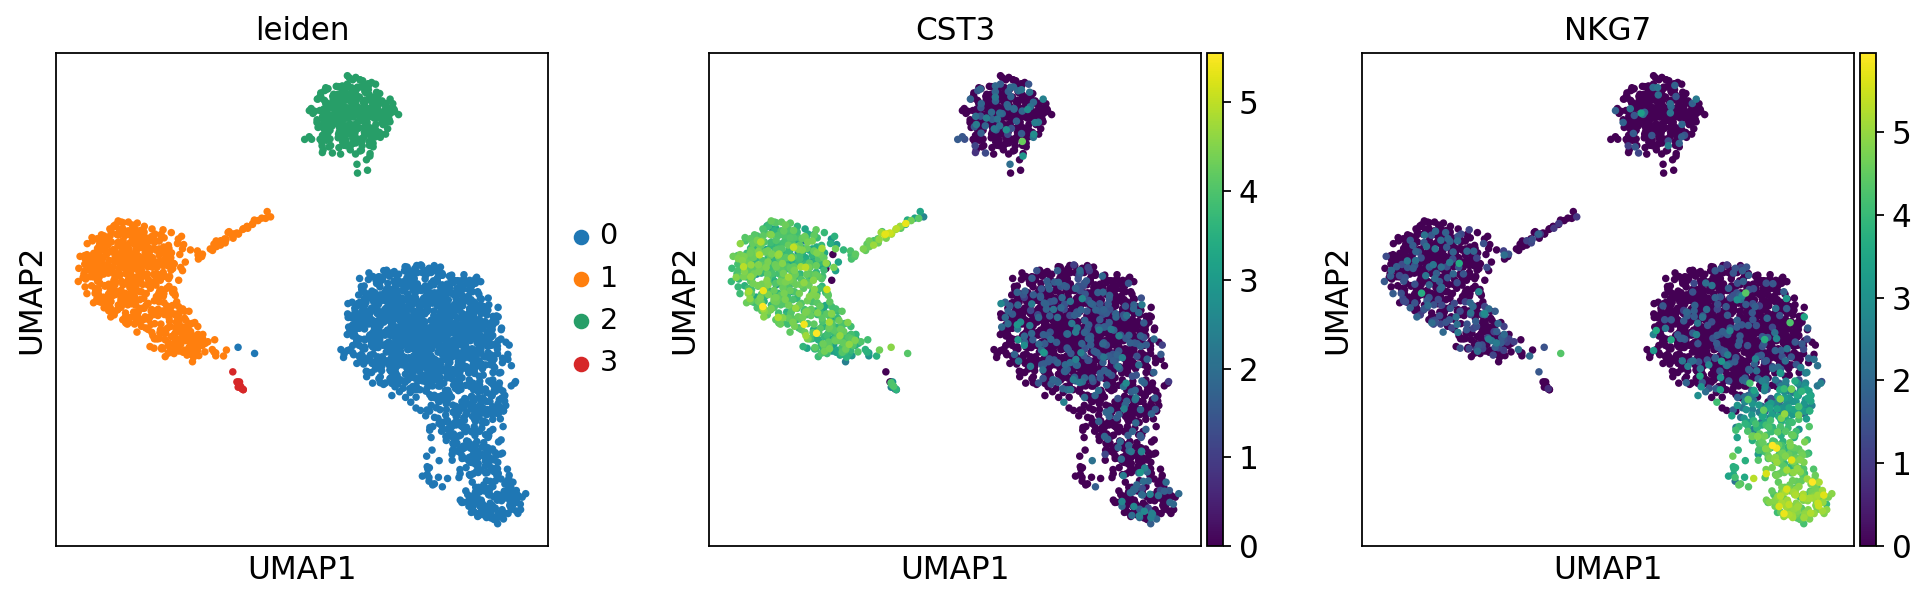

In [36]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [37]:
adata.write('results_file.h5ad')



ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


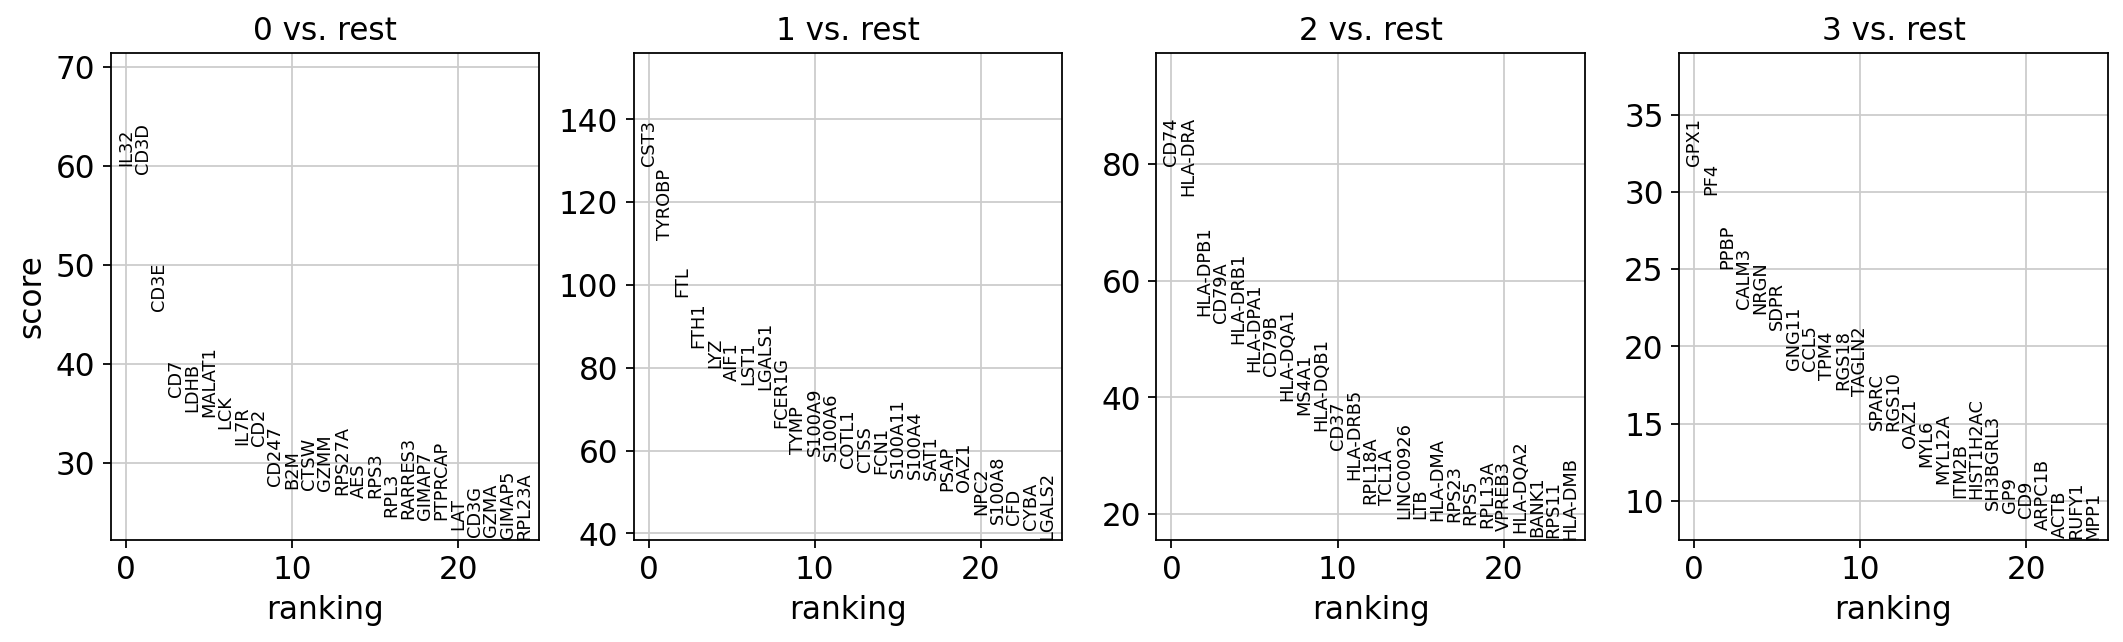

In [38]:
# searching for marker genes 
# we test each cluster against the rest and identify the most variable gene (the one that is significantly expressed in the cluster)

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# plots only the genes that are expressed in a specific cluster against the rest

In [39]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:01)


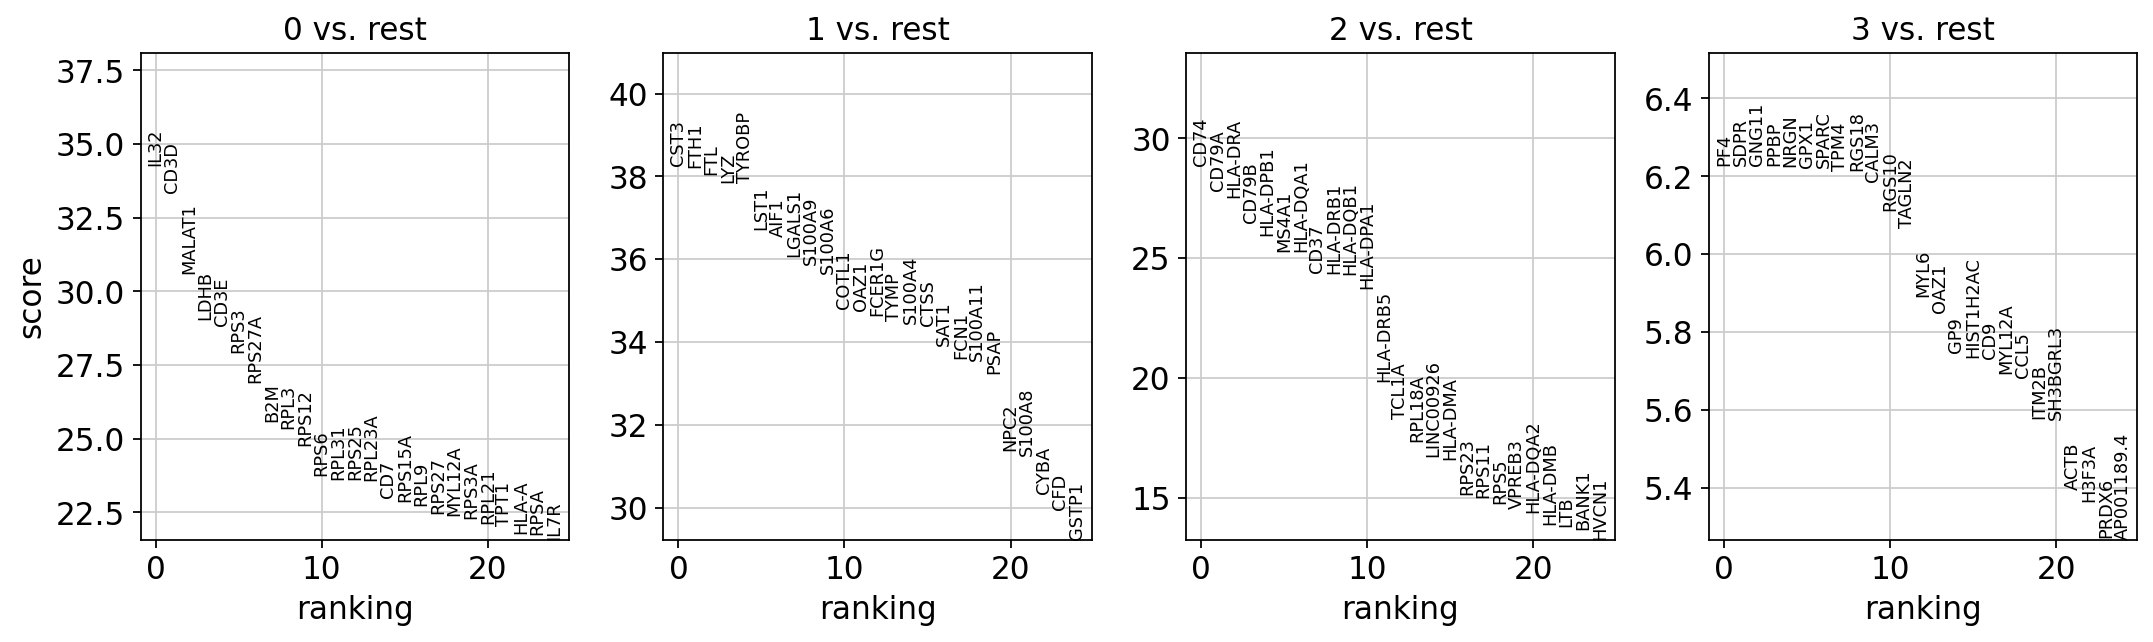

In [40]:
# same thing with differnent method for identifying siginficantly different expressed genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [42]:
adata.write(results_file)

ranking genes
    finished (0:00:03)


/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


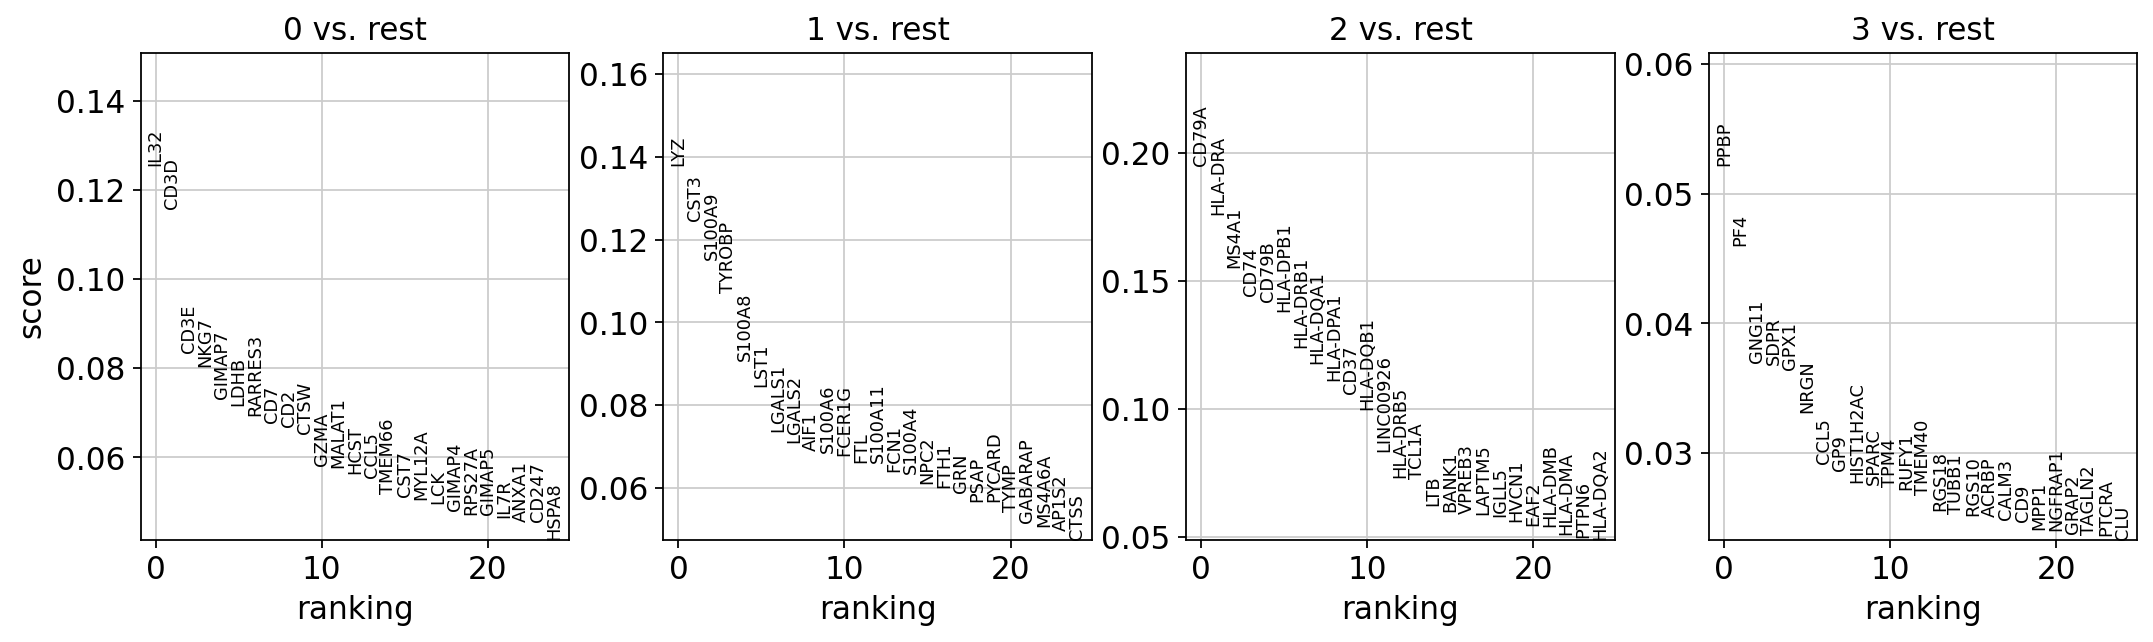

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [44]:
# are these genes highly specifiy to each particular cluster; how do i identify them ?? 
# Louvain Group	Markers	Cell Type
# 0	IL7R	CD4 T cells
#1	CD14, LYZ	CD14+ Monocytes
#2	MS4A1	B cells
#3	CD8A	CD8 T cells
#4	GNLY, NKG7	NK cells
#5	FCGR3A, MS4A7	FCGR3A+ Monocytes
#6	FCER1A, CST3	Dendritic Cells
#7	PPBP	Megakaryocytes


In [45]:
# there are known marker genes in literature
# then we look if any marker genes are uniquely expressed in a cluster

marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']


In [47]:
adata = sc.read(results_file)

In [48]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
# columns = clusters 
# rows = ranked genes

,0,1,2,3
0,IL32,CST3,CD74,PF4
1,CD3D,FTH1,CD79A,SDPR
2,MALAT1,FTL,HLA-DRA,GNG11
3,LDHB,LYZ,CD79B,PPBP
4,CD3E,TYROBP,HLA-DPB1,NRGN


In [49]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

# same table but with p values // how likely is it that this gene is expressed by chance

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p
0,IL32,1.759198e-257,CST3,0.0,CD74,2.487145e-183,PF4,4.722886e-10
1,CD3D,8.885569e-244,FTH1,0.0,CD79A,1.679730e-170,SDPR,4.733899e-10
2,MALAT1,8.531804e-206,FTL,0.0,HLA-DRA,6.942399e-167,GNG11,4.733899e-10
3,LDHB,2.373368e-185,LYZ,0.0,CD79B,2.569135e-154,PPBP,4.744938e-10
4,CD3E,9.190561e-183,TYROBP,0.0,HLA-DPB1,3.580735e-148,NRGN,4.800511e-10


ranking genes
    finished (0:00:01)


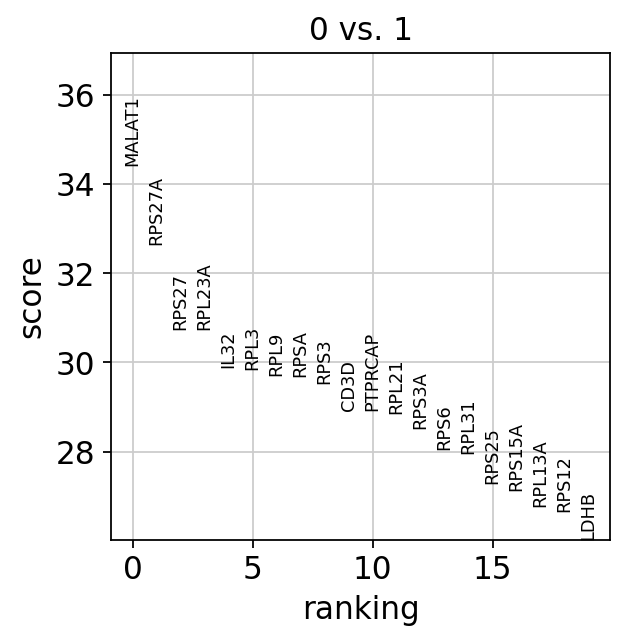

In [50]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)
# i don't understand these

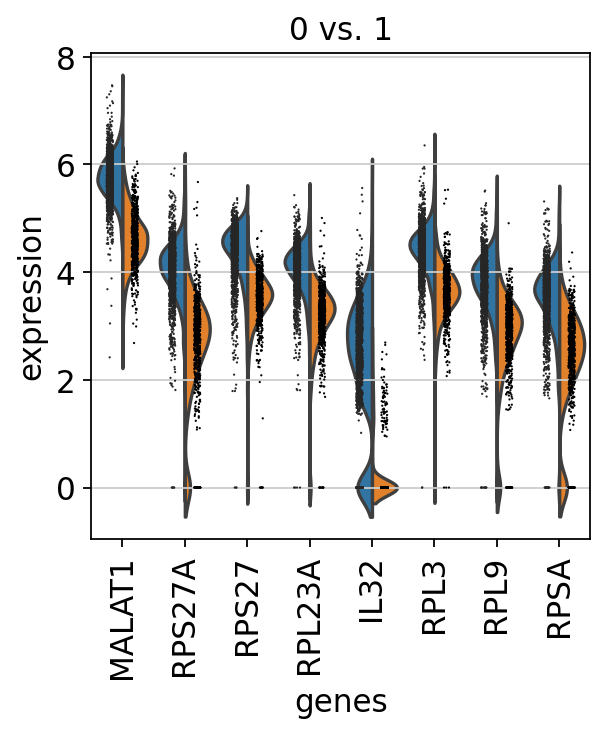

In [51]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [54]:
adata = sc.read(results_file)

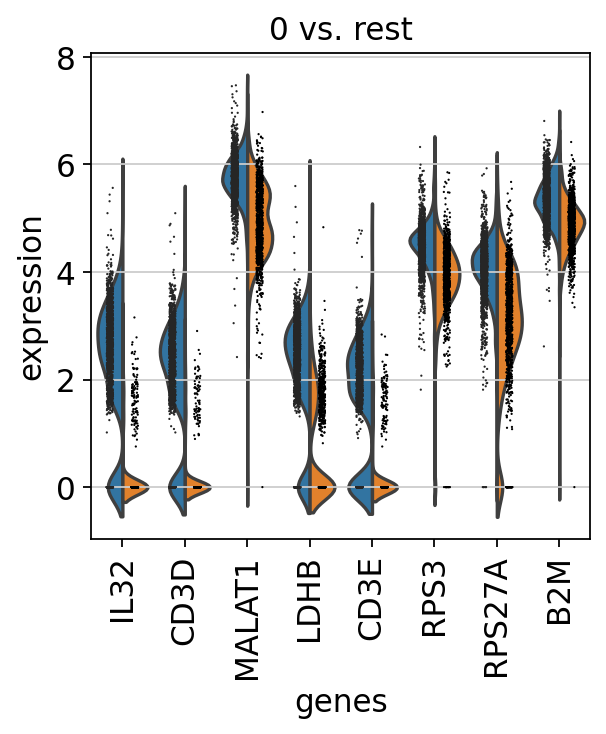

In [55]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/benjaminkroeger/anaconda3/envs/GRN_inference/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an exp

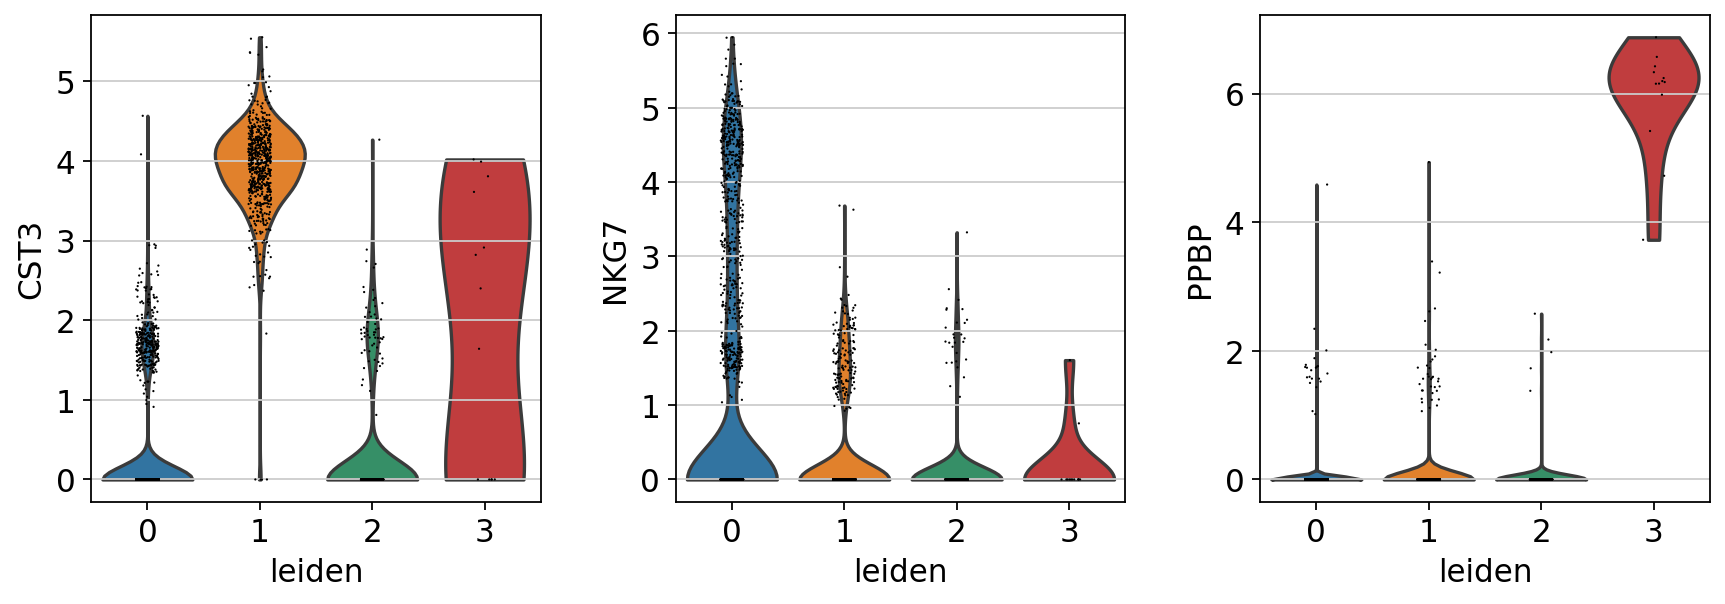

In [56]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')
# plot expression of these 3 genes in all of the clustesrs

In [57]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    ]
adata.rename_categories('leiden', new_cluster_names)

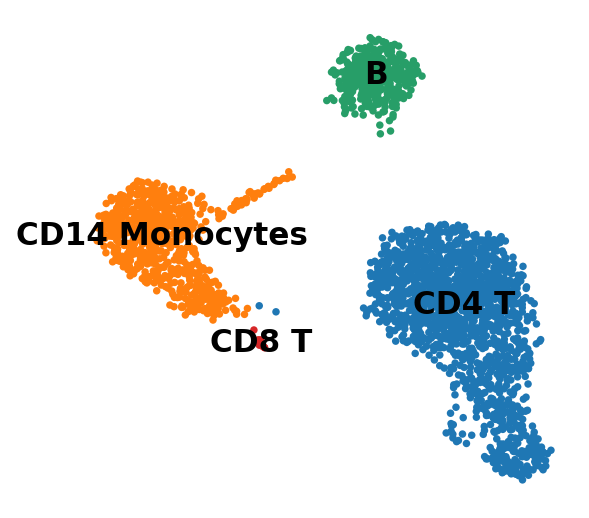

In [58]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

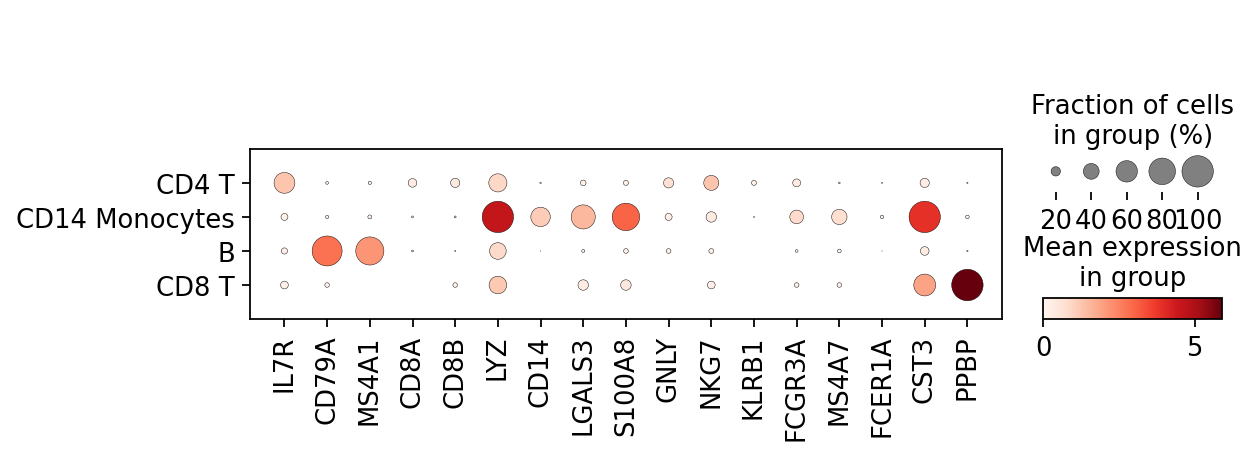

In [59]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

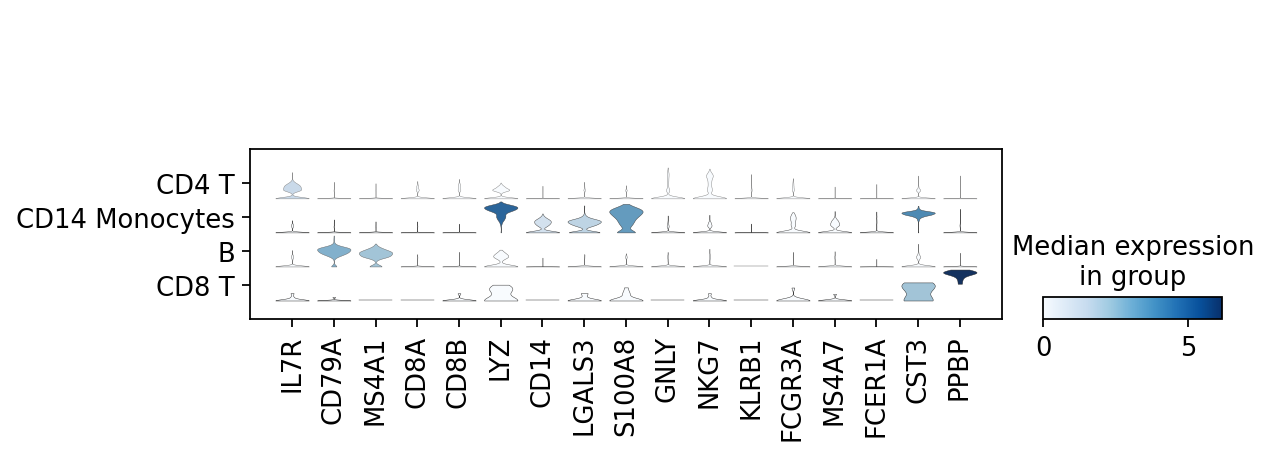

In [60]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);